In [88]:
using Plots
#Pkg.add("LinearLeastSquares")
#Pkg.update()
using LinearLeastSquares
using Optim

In [89]:
x_values = [0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95]
y_values = [11.3,19.9,24.9,31.1,37.2,36.0,59.1,77.2,96.0,90.3,72.2,89.9,91.0,102.0,109.7,116.0,126.6,139.8]
x_values_cont = linspace(x_values[1],x_values[end],200)

0.1:0.004271356783919598:0.95


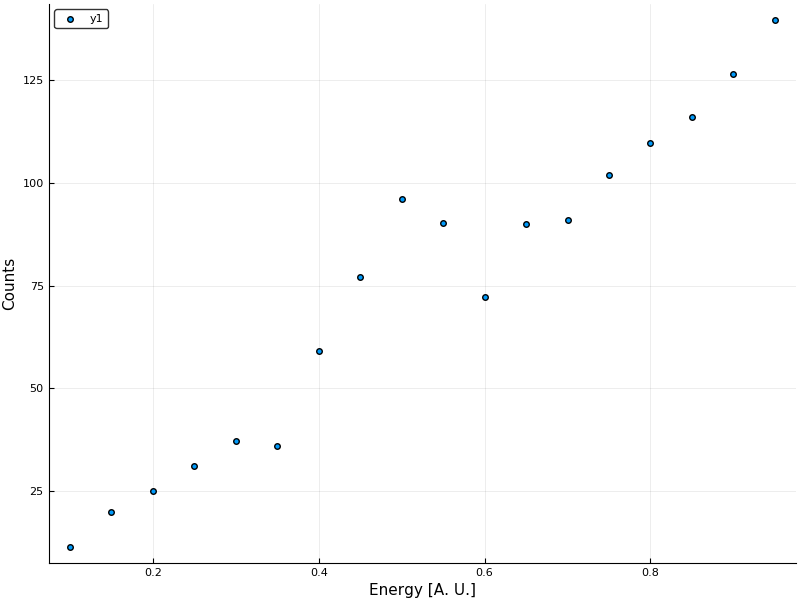

In [90]:
scatter(x_values,y_values,size=(800,600),ylabel="Counts",xlabel="Energy [A. U.]")

In [91]:
function model_a(x,p)
    A=p[1]
    B=p[2]
    C=p[3]
    @. return A+B*x+C*x^2
end

function model_b(x,p)
    A=p[1]
    B=p[2]
    C=p[3]
    D=p[4]
    x0=p[5]
    G=p[6]
    sum1= @. A+B*x+C*x^2
    sum2= @. D/((x-x0)^2+G^2)
    return sum1+sum2
end

model_b (generic function with 1 method)

d: Amplitude of Signal

x0: Location of Signal

Gamma: Width of Signal

In [92]:
function chi2_a(x_values,y_values,model,p)
    chi2=0.0
    for (i, x) in enumerate(x_values)
        chi2+=(y_values[i]-model(x,p))^2/(4.0^2)
    end
    return chi2
end

function optimize_chi2(x_values::Array{T1,N}, y_values::Array{T2, N}, model::Function, p0::Array{T3,N}; minimizer=NelderMead()) where T1<:Real where T2<:Real where T3<:Real where N
        return optimize(p->chi2_a(x_values, y_values, model, p), p0, minimizer)
end


optimize_chi2 (generic function with 1 method)

In [93]:
initial_parameters_a = [5.,140.,30.]
p_fit_a = optimize_chi2(x_values,y_values,model_a,initial_parameters_a)

Results of Optimization Algorithm
 * Algorithm: Nelder-Mead
 * Starting Point: [5.0,140.0,30.0]
 * Minimizer: [-7.267225783118617,173.4649558061147, ...]
 * Minimum: 9.250651e+01
 * Iterations: 133
 * Convergence: true
   *  √(Σ(yᵢ-ȳ)²)/n < 1.0e-08: true
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 251

[-7.26723, 173.465, -28.8756]



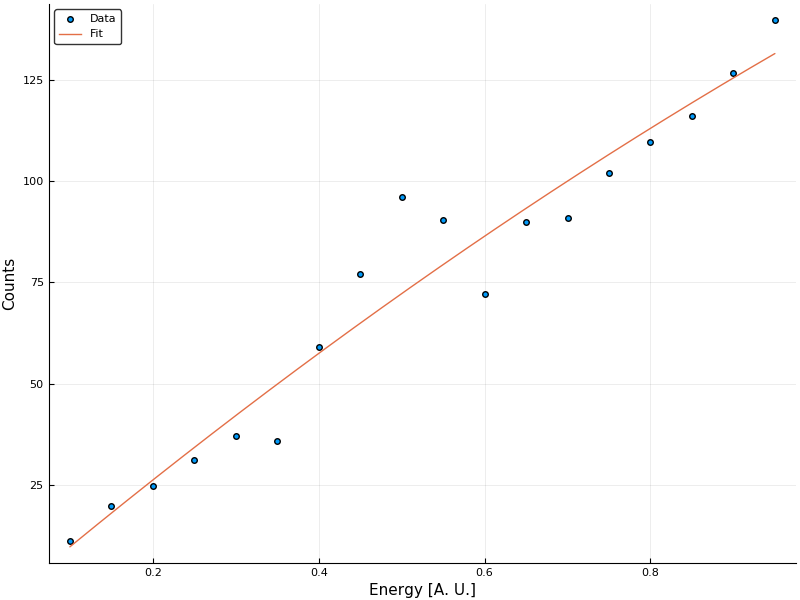

In [94]:
println(p_fit_a.minimizer)
scatter(x_values,y_values,size = (800,600),ylabel="Counts",xlabel="Energy [A. U.]",label="Data")
plot!(x_values_cont, model_a(x_values_cont,p_fit_a.minimizer),label="Fit")


In [95]:
initial_parameters_b = [5.0,50.0,50.0,0.5,0.5,0.5]
p_fit_b=optimize_chi2(x_values,y_values,model_b,initial_parameters_b)

Results of Optimization Algorithm
 * Algorithm: Nelder-Mead
 * Starting Point: [5.0,50.0,50.0,0.5,0.5,0.5]
 * Minimizer: [6.706335827607866,56.79471754472499, ...]
 * Minimum: 1.499230e+01
 * Iterations: 498
 * Convergence: true
   *  √(Σ(yᵢ-ȳ)²)/n < 1.0e-08: true
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 825

[6.70634, 56.7947, 85.5069, 0.15549, 0.493324, 0.0615687]



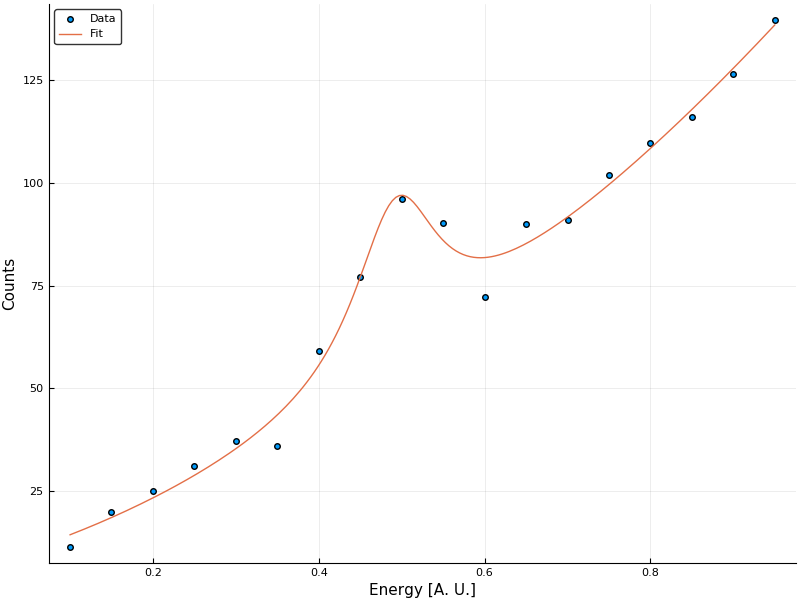

In [96]:
println(p_fit_b.minimizer)
#field_values(p_fit_b)
scatter(x_values,y_values,ylabel="Counts",xlabel="Energy [A. U.]",label="Data",size=(800,600))
plot!(x_values_cont, model_b(x_values_cont,p_fit_b.minimizer),label="Fit")


# Covariance Matrices

In [97]:
using LsqFit
function print_matrix(m)
    for i in 1:size(m,1)
        line=""
        for j in 1:size(m,2)
            line=line*"$(round(m[i,j],3))\t\t"
        end
        println(line)
    end
end
    

print_matrix (generic function with 1 method)

In [98]:
fit_a = curve_fit(model_a,x_values,y_values,initial_parameters_a)
fit_param_a = fit_a.param
dof_a = fit_a.dof
cov_a = estimate_covar(fit_a)
println("Fit Parameters: $fit_param_a")
println("Degrees of Freedom: $dof_a")
println("Covariance Matrix:")
print_matrix(cov_a)

Fit Parameters: [-7.26758, 173.467, -28.8777]
Degrees of Freedom: 15
Covariance Matrix:
94.231		-376.9		318.22		
-376.9		1765.484		-1603.828		
318.22		-1603.828		1527.455		


In [99]:
fit_b = curve_fit(model_b,x_values,y_values,initial_parameters_b)
fit_param_b = fit_b.param
dof_b = fit_b.dof
cov_b = estimate_covar(fit_b)
println("Fit Parameters: $fit_param_b")
println("Degrees of Freedom: $dof_b")
println("Covariance Matrix:")
print_matrix(cov_b)

Fit Parameters: [6.70632, 56.7946, 85.5069, 0.155492, 0.493324, 0.0615689]
Degrees of Freedom: 12
Covariance Matrix:
25.584		-136.049		122.546		0.167		0.006		0.026		
-136.049		930.046		-884.953		-1.712		-0.033		-0.278		
122.546		-884.953		858.033		1.679		0.027		0.273		
0.167		-1.712		1.679		0.006		0.0		0.001		
0.006		-0.033		0.027		0.0		0.0		0.0		
0.026		-0.278		0.273		0.001		0.0		0.0		


# Calculate the p-Values


In [100]:
function chi2_dist(chi2,n)
    @. return(chi2^(n/2 -1))/(2^(n/2)*gamma(n/2))*exp(-chi2/2)
end

chi2_dist (generic function with 1 method)

In [101]:
n_a= length(x_values)-length(initial_parameters_a)
n_b= length(x_values)-length(initial_parameters_b)
println("Degrees of Freedom using model A: $n_a")
println("Degrees of Freedom using model B: $n_b")
chi2_a_m = chi2_a(x_values,y_values,model_a,p_fit_a.minimizer)
chi2_b_m = chi2_a(x_values,y_values,model_b,p_fit_b.minimizer)

Degrees of Freedom using model A: 15
Degrees of Freedom using model B: 12


14.992304978097884


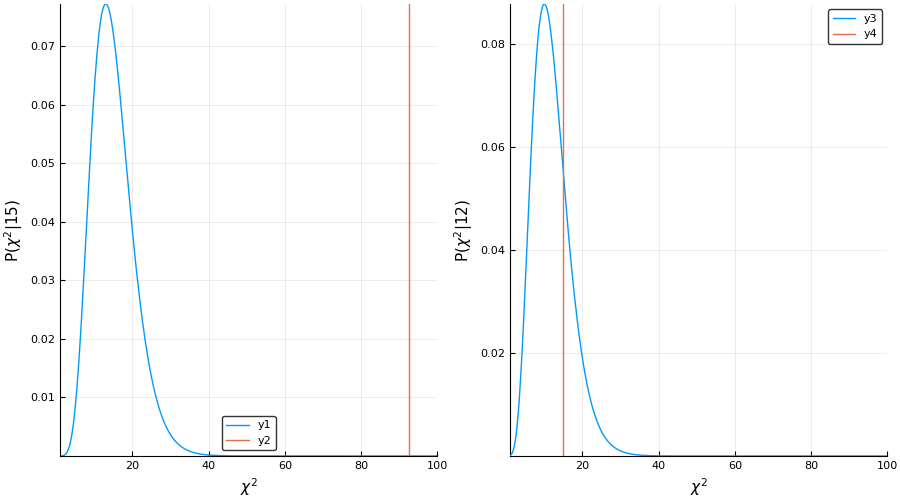

In [110]:

l2 = @layout [a b]
p = plot(layout=l2,size = (900,500),xlabel="\$\\chi^{2}\$")
chi2_range = linspace(1,100,400)
plot!(p[1],chi2_range,chi2_dist(chi2_range,n_a),ylabel="P(\$\\chi^{2}\$|15)")
vline!(p[1],[chi2_a_m])
plot!(p[2],chi2_range,chi2_dist(chi2_range,n_b),fill=(0:20,:green),ylabel="P(\$\\chi^{2}\$|12)")
vline!(p[2],[chi2_b_m])

In [13]:
function calculate_p_value(chi2_m,n,stepsize=0.001)
    Integral=0.0
    for chi2 in chi2_m:stepsize:100*chi2_m
        Integral+=chi2_dist(chi2,n)*stepsize
    end
    return Integral
end


calculate_p_value (generic function with 2 methods)

In [14]:
println(calculate_p_value(chi2_a_m,n_a))
println(calculate_p_value(chi2_b_m,n_b))

3.372358706994305e-13
0.24188492027683575
